# [기본과제] MNIST 분류(classification) 모델 구현

- 풀고자 하는 문제는, 흑백 손글씨 이미지를 보고, 이 손글씨가 0 ~ 9 중 어떤 숫자인지를 맞추는 문제입니다.
- 즉, 흑백 이미지를 0 ~ 9, 총 10개의 숫자로 분류를 해야합니다.
- 그래서 MNIST 데이터셋을 input 으로 받아서 10 개의 숫자 중 1개로 분류해주는 Classification Model 을 만들어 보겠습니다.  


In [1]:
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from matplotlib import pyplot as plt

In [2]:
DIR_ROOT_DATA = "../data"

MNIST_BATCH_SIZE = 256
MNIST_NUM_EPOCHS = 100
MNIST_LEARNING_RATE = 0.001

## 편의 기능 함수
- 사용 가능한 torch.device 가져오는 함수
- 모델에 대해서, 정확도를 계산해주는 함수

In [3]:
def get_device() -> torch.device:
    """
    mps, cuda, cpu 순으로 사용 가능을 체크해서 반환
    :return: 사용 가능한 pytorch device
    """
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def calculate_accuracy(
    device: torch.device, model: nn.Module, data_loader: torch.utils.data.DataLoader
) -> float:
    """
    model 에 대한 평가를 진행하여, 예측의 정확도를 계산
    :return: 정확도
    """
    total = 0
    num_correctness = 0

    model.eval()
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            inputs, labels = images.to(device), labels.to(device)

            outputs = model(inputs)

            total += labels.size(0)

            predictions = torch.argmax(outputs, dim=1)
            num_correctness += (predictions == labels).sum().item()
    model.train()

    return num_correctness / total

In [4]:
transform = transforms.ToTensor()

mnist_train_set = torchvision.datasets.MNIST(
    root=DIR_ROOT_DATA, train=True, download=True, transform=transform
)
mnist_train_loader = torch.utils.data.DataLoader(
    mnist_train_set,
    batch_size=MNIST_BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

mnist_test_set = torchvision.datasets.MNIST(
    root=DIR_ROOT_DATA, train=False, download=True, transform=transform
)
mnist_test_loader = torch.utils.data.DataLoader(
    mnist_test_set, batch_size=MNIST_BATCH_SIZE, shuffle=False
)

## MNIST 데이터셋
- 0 ~ 9 까지의 숫자에 대한 손글씨 이미지로, 흑백 이미지
- 다음은 데이터셋의 클래스이다.
    - 레이블 0: 숫자 0
    - 레이블 1: 숫자 1
    - 레이블 2: 숫자 2
    - 레이블 3: 숫자 3
    - 레이블 4: 숫자 4
    - 레이블 5: 숫자 5
    - 레이블 6: 숫자 6
    - 레이블 7: 숫자 7
    - 레이블 8: 숫자 8
    - 레이블 9: 숫자 9

mnist_images.shape: torch.Size([256, 1, 28, 28])
label: 7


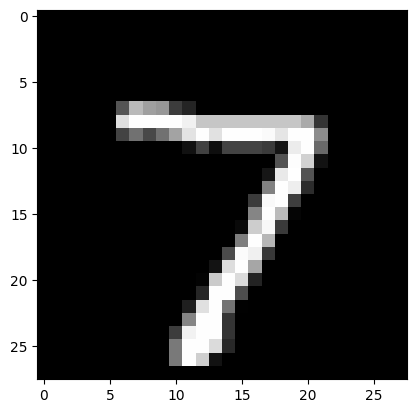

In [5]:
mnist_images, mnist_labels = next(iter(mnist_test_loader))
print("mnist_images.shape:", mnist_images.shape)

print("label:", mnist_labels[0].item())
plt.imshow(transforms.ToPILImage()(mnist_images[0]), cmap="gray")

## MNIST 데이터를 분류하는 모델 정의

In [6]:
class MNISTClassificationModel(nn.Module):
    def __init__(self):
        super(MNISTClassificationModel, self).__init__()

        input_dim = 1 * 28 * 28  # input dimension 은 이미지의 크기
        hidden_dim = 1024
        num_classes = 10  # output dimension 은 0 ~ 9 까지의 분류

        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, num_classes)

        self.activation = nn.ReLU()

    def forward(self, x):
        # x.shape: (batch_size, 1, 28, 28)
        x = torch.flatten(x, start_dim=1)  # x.shape: (batch_size, 1* 28 * 28)
        x = self.activation(self.layer1(x))  # x.shape: (batch_size, hidden_dim)
        x = self.activation(self.layer2(x))  # x.shape: (batch_size, hidden_dim)
        x = self.layer3(x)  # x.shape: (batch_size, 10)
        return x

In [7]:
device = get_device()
device

device(type='mps')

In [8]:
mnist_model = MNISTClassificationModel().to(device)
mnist_model

MNISTClassificationModel(
  (layer1): Linear(in_features=784, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=10, bias=True)
  (activation): ReLU()
)

## Cross Entropy Loss 함수
- Cross Entropy Loss (교차 엔트로피 손실)는 분류 문제에서 널리 사용되는 손실 함수
- 이 함수는 모델의 예측 확률 분포와 실제 레이블의 확률 분포 간의 차이를 측정

### 수식
$$L = -\sum_{i=1}^{C} y_i \log(p_i)$$
- $C$는 클래스의 수
- $y_i$는 실제 레이블 (원-핫 인코딩)
- $p_i$는 클래스 $i$에 대한 모델의 예측 확률

### MNIST 분류에서의 사용 이유
- 확률적 해석 
   - Cross Entropy Loss를 사용하면 모델의 출력을 확률로 해석할 수 있습니다.
   - MNIST에서 각 숫자(0-9)에 대한 예측 확률을 직접적으로 얻을 수 있습니다.

- 학습 효율성 
   - 오차가 클수록 더 큰 페널티를 부여합니다.
   - 이는 모델이 잘못된 예측에 대해 더 빠르게 학습하도록 유도합니다.

- 다중 클래스 적합성 
   - MNIST는 10개의 클래스(0-9)를 가진 다중 클래스 문제입니다.
   - Cross Entropy Loss는 다중 클래스 분류에 자연스럽게 적용됩니다.

- 미분 가능성 
   - 이 손실 함수는 연속적이고 미분 가능합니다.
   - 이는 역전파 알고리즘을 사용한 신경망 학습에 필수적입니다.


In [9]:
# '손실 함수'를 'criterion'이라고 부르는 것은 PyTorch 의 관행
# 단순히 '손실'을 넘어 '평가 기준'이라는 더 넓은 의미를 가짐
# 이는 모델의 성능을 평가하고 최적화하는 기준이 됨
mnist_criterion = nn.CrossEntropyLoss()
mnist_criterion

CrossEntropyLoss()

In [10]:
mnist_optimizer = optim.SGD(mnist_model.parameters(), lr=MNIST_LEARNING_RATE)
mnist_optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## 학습
- 매 epoch 마다의 모델을 가지고, train 데이터와 test 데이터에 대한 정확도 측정

In [11]:
mnist_accuracies = np.zeros((2, MNIST_NUM_EPOCHS))  # training_accuracy, test_accuracy

for epoch in range(MNIST_NUM_EPOCHS):
    for data in mnist_train_loader:
        mnist_optimizer.zero_grad()

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)

        outputs = mnist_model(inputs)  # logits 이 출력됨.

        loss = mnist_criterion(
            outputs, labels
        )  # cross entropy 에는 나온 출력값(logits) 그대로 넣어준다.
        loss.backward()

        mnist_optimizer.step()

    mnist_accuracies[0][epoch] = calculate_accuracy(
        device, mnist_model, mnist_train_loader
    )
    mnist_accuracies[1][epoch] = calculate_accuracy(
        device, mnist_model, mnist_test_loader
    )

    print(f"Epoch {epoch + 1:3d}, Training Accuracy: {mnist_accuracies[0][epoch]:.5f}")

Epoch   1, Training Accuracy: 0.14430
Epoch   2, Training Accuracy: 0.22190
Epoch   3, Training Accuracy: 0.35168
Epoch   4, Training Accuracy: 0.46183
Epoch   5, Training Accuracy: 0.53535
Epoch   6, Training Accuracy: 0.58775
Epoch   7, Training Accuracy: 0.62493
Epoch   8, Training Accuracy: 0.65072
Epoch   9, Training Accuracy: 0.66923
Epoch  10, Training Accuracy: 0.68358
Epoch  11, Training Accuracy: 0.69483
Epoch  12, Training Accuracy: 0.70680
Epoch  13, Training Accuracy: 0.71637
Epoch  14, Training Accuracy: 0.72470
Epoch  15, Training Accuracy: 0.72990
Epoch  16, Training Accuracy: 0.73483
Epoch  17, Training Accuracy: 0.73810
Epoch  18, Training Accuracy: 0.74328
Epoch  19, Training Accuracy: 0.74825
Epoch  20, Training Accuracy: 0.75470
Epoch  21, Training Accuracy: 0.76223
Epoch  22, Training Accuracy: 0.77085
Epoch  23, Training Accuracy: 0.77937
Epoch  24, Training Accuracy: 0.78607
Epoch  25, Training Accuracy: 0.79360
Epoch  26, Training Accuracy: 0.79987
Epoch  27, T

## 각 Epoch 별 모델에 대한 Accuracy 그래프

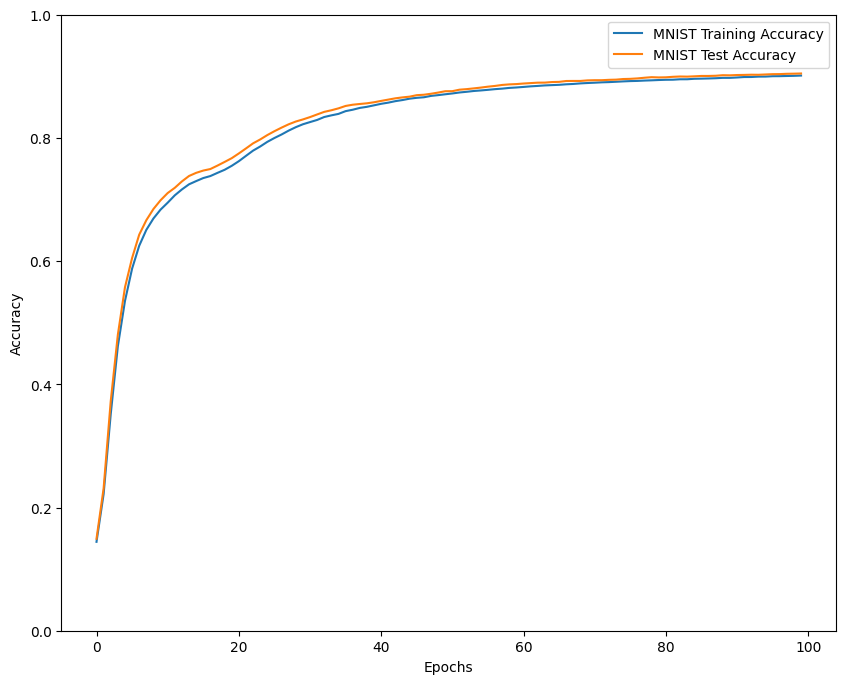

In [12]:
plt.figure(figsize=(10, 8))

x_axis = np.arange(MNIST_NUM_EPOCHS)
plt.plot(x_axis, mnist_accuracies[0], label="MNIST Training Accuracy")
plt.plot(x_axis, mnist_accuracies[1], label="MNIST Test Accuracy")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()